# imports & init

In [2]:
import wandb
from dotenv import load_dotenv
try:
    import google.colab
    IN_COLAB = True
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install einops
    !pip install https://github.com/neelnanda-io/TransformerLens@no-position-experiment
    !pip install transformer_lens
    !pip install wandb
    !pip install python-dotenv

    # for wandb logging, make a credentials file that looks like this:
    # $ cat drive/MyDrive/ML/credentials/credentials.env
    # WANDB_API_KEY=YOUR_KEY_HERE
    # WANDB_PROJECT=oocl
    # WANDB_ENTITY=asic_oocl

    assert load_dotenv(dotenv_path="drive/MyDrive/ML/credentials/credentials.env")
    wandb.login(key=os.getenv("WANDB_API_KEY"))
    dir_models = "drive/MyDrive/ML/models/transformers/"  # save models here
except:
    IN_COLAB = False
    assert load_dotenv()
    wandb.login(key=os.getenv("WANDB_API_KEY"))
    dir_models = "models/transformers/"  # save models here

from transformer_lens import HookedTransformer, HookedTransformerConfig
import torch
import numpy as np
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "colab"
import tqdm.auto as tqdm
import einops
from transformer_lens.utils import to_numpy
import os
from datetime import datetime
import time
from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/andrei/.netrc
/home/andrei/.pyenv/versions/3.12.1/envs/mechint/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def line(tensor, line_labels=None, yaxis="", xaxis="", **kwargs):
    tensor = to_numpy(tensor)
    labels = {"y": yaxis, "x": xaxis}
    fig = px.line(tensor, labels=labels, **kwargs)
    if line_labels:
        for c, label in enumerate(line_labels):
            fig.data[c].name = label
    fig.show()


def imshow(tensor, yaxis="", xaxis="", **kwargs):
    tensor = to_numpy(tensor)
    plot_kwargs = {
        "color_continuous_scale": "RdBu",
        "color_continuous_midpoint": 0.0,
        "labels": {"x": xaxis, "y": yaxis},
    }
    plot_kwargs.update(kwargs)
    px.imshow(tensor, **plot_kwargs).show()

# data generation & training info

In [5]:
def make_data_generator(cfg, batch_size, seed=123, incl_bos_token=True):
    # the first group data looks like A, B and B, C with equal prob
    # other group data looks like A, B and B, C and C, A with equal prob

    torch.manual_seed(seed)
    while True:
        nb = batch_size
        ng = n_groups

        g_b = torch.randint(0, ng, (nb, )) # dim=[batch,]
        x_bc = torch.empty((nb, cfg.n_ctx), dtype=torch.long) # dim=[batch, n_ctx]
        # x_bc[:, 0] = g_b * size_group

        i_b = torch.rand((nb, ))

        # the first group data looks like A, B and B, C with equal prob
        x_bc[(g_b == 0) & (i_b <= 0.5), 0] = 0
        x_bc[(g_b == 0) & (i_b <= 0.5), 1] = 1
        x_bc[(g_b == 0) & (i_b >  0.5), 0] = 1
        x_bc[(g_b == 0) & (i_b >  0.5), 1] = 2

        # other group data looks like (A, B) and (B, C) and (C, A) with equal prob
        m_b = torch.randint(0, nm, (nb, )) # "relative" group member position
        i = g_b != 0
        x_bc[i, 0] = (g_b * nm + m_b)[i]
        x_bc[i, 1] = (g_b * nm + ((m_b + 1) % nm))[i]
        yield x_bc

# data_generator = make_data_generator(cfg, 16)
# print(next(data_generator))

In [6]:
def loss_fn(logits, tokens, per_token=False):
    # logit shape: [batch, pos, vocab]
    # token shape: [batch, pos]
    logits = logits[:, :-1]
    tokens = tokens[:, 1:]
    log_probs = logits.log_softmax(-1)
    correct_log_probs = log_probs.gather(-1, tokens[..., None])[..., 0]
    if per_token:
        return -correct_log_probs
    else:
        return -correct_log_probs.mean()

# spec out and train the models

In [7]:
details = []

In [37]:
batch_size = 2**10
num_epochs = 100000
lr = 1e-4
betas = (0.9, 0.95)
max_grad_norm = 1.0
wd = 0.1

In [38]:
# n_layers_list = [2**i for i in range(1)]  # attempt oocl for bigger and bigger models
n_layers_list = [4]
n_groups = 10000
size_group = 3  # e.g. A, B, C form a group
nm = size_group  # number of members in group
default_transformer_config = dict(
    d_model=2**6,
    d_head=2**6,
    n_heads=4,
    d_mlp=2**6,
    d_vocab=nm * n_groups,
    n_ctx=2,
    act_fn="relu",
    normalization_type="LN",
)
cfgs = [
    HookedTransformerConfig(
        n_layers=n_layers,
        **default_transformer_config,
    ) for n_layers in n_layers_list
]
for i_cfg, cfg in enumerate(cfgs):
    ts_start_training = time.time()
    name = f"tiny_{cfg.n_layers:04}"
    wandb.init(
        # set the wandb project where this run will be logged
        project=os.getenv("WANDB_PROJECT"),
        entity=os.getenv("WANDB_ENTITY"),
        name=name,

        # track hyperparameters and run metadata
        config={
            "n_layers": cfg.n_layers,
            "n_groups": n_groups,
            "lr": lr,
            "wd": wd,
            "batch_size": batch_size,
            **default_transformer_config,
        }
    )
    print(f"n_layers={cfg.n_layers}")
    model = HookedTransformer(cfg)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=betas, weight_decay=wd)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda i: min(i / 1000, 1.0))
    # scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-1, step_size_up=num_epochs//4, last_epoch=-1, cycle_momentum=True)
    data_loader = make_data_generator(cfg, batch_size)
    # losses, ranks = [], []
    with tqdm(total=num_epochs, position=0, leave=True) as pbar:
        for epoch in tqdm(range(num_epochs), position=i_cfg, leave=True):
            tokens = next(data_loader)
            tokens = tokens.cuda()
            logits = model(tokens)
            loss = loss_fn(logits, tokens)
            loss.backward()
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            # losses.append(loss.item())
            if epoch % 250 == 0:
                print(f"Epoch {epoch}: {loss.item():.5f}, lr: {scheduler.get_last_lr()[0]:.5f}", end=", ")
    
                # Test how the desired token stacks up
                model.eval()
                with torch.no_grad():
                    tokens = torch.tensor([[2, 1]], dtype=torch.long, device=device)
                    logits = model(tokens)
                    probs = logits[0][0].softmax(dim=0)
                    rank = probs.argsort()[0].item()
                    # ranks.append(rank)
    
                    # details.append({
                    #     "step": epoch,
                    #     "n_layers": cfg.n_layers,
                    #     "loss": loss.item(),
                    #     "rank": rank,
                    #     "prob": probs[0].item(),
                    #     "n_groups": n_groups,
                    #     "ts": datetime.now(),
                    # })
                    prob_mult = probs[0].item() * n_groups * nm  # multiple of "naive prior"
                    print(f"ooc tgt rank: {rank}, ooc prob: {prob_mult:.2f}")
                    wandb.log({
                        "train_loss": loss.item(),
                        "target_rank": rank,
                        "target_prob_mult": prob_mult,
                    })
                model.train()
            pbar.update()
    ts_finish_training = time.time()
    wandb.finish()
    print(f"training n_layers={cfg.n_layers} took {(ts_finish_training - ts_start_training)//60} minutes")
    torch.save(model.state_dict(), os.path.join(dir_models, name))

target_prob_mult,▃▃▁▅█▇▇▆▆▅▅▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
target_rank,▁██▃▃▆▆▆▆▆█▆▄▆▄▄▄▄▄▆▆▆▆▄▄▄▄▄▄▄▄▄▄▄▁▁▁▁▁▁
train_loss,██▇▆▅▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂
target_prob_mult,0.67463
target_rank,1643
train_loss,8.40584


n_layers=4


  0%|                                                                                                                                                                                                                  | 1/100000 [00:00<8:53:43,  3.12it/s]

Epoch 0: 10.64192, lr: 0.00000, ooc tgt rank: 24878, ooc prob: 1.71


  0%|▌                                                                                                                                                                                                               | 252/100000 [00:21<2:22:29, 11.67it/s]

Epoch 250: 10.55517, lr: 0.00003, ooc tgt rank: 24878, ooc prob: 1.92


  1%|█                                                                                                                                                                                                               | 502/100000 [00:41<2:19:40, 11.87it/s]

Epoch 500: 10.34194, lr: 0.00005, ooc tgt rank: 16791, ooc prob: 1.84


  1%|█▌                                                                                                                                                                                                              | 752/100000 [01:02<2:17:54, 12.00it/s]

Epoch 750: 10.08525, lr: 0.00008, ooc tgt rank: 20065, ooc prob: 1.26


  1%|██                                                                                                                                                                                                             | 1002/100000 [01:23<2:27:41, 11.17it/s]

Epoch 1000: 9.78589, lr: 0.00010, ooc tgt rank: 20065, ooc prob: 0.98


  1%|██▌                                                                                                                                                                                                            | 1252/100000 [01:44<2:28:36, 11.07it/s]

Epoch 1250: 9.32206, lr: 0.00010, ooc tgt rank: 26846, ooc prob: 0.87


  2%|███                                                                                                                                                                                                            | 1502/100000 [02:04<2:17:02, 11.98it/s]

Epoch 1500: 9.00899, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.70


  2%|███▋                                                                                                                                                                                                           | 1752/100000 [02:25<2:20:37, 11.64it/s]

Epoch 1750: 8.63503, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.61


  2%|████▏                                                                                                                                                                                                          | 2002/100000 [02:45<2:19:12, 11.73it/s]

Epoch 2000: 8.23506, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.63


  2%|████▋                                                                                                                                                                                                          | 2252/100000 [03:06<2:17:55, 11.81it/s]

Epoch 2250: 7.84191, lr: 0.00010, ooc tgt rank: 15412, ooc prob: 0.61


  3%|█████▏                                                                                                                                                                                                         | 2502/100000 [03:27<2:31:34, 10.72it/s]

Epoch 2500: 7.54845, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.60


  3%|█████▋                                                                                                                                                                                                         | 2752/100000 [03:48<2:23:42, 11.28it/s]

Epoch 2750: 7.15664, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.58


  3%|██████▏                                                                                                                                                                                                        | 3002/100000 [04:09<2:18:20, 11.69it/s]

Epoch 3000: 6.81204, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.53


  3%|██████▋                                                                                                                                                                                                        | 3252/100000 [04:29<2:11:28, 12.26it/s]

Epoch 3250: 6.47807, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.51


  4%|███████▏                                                                                                                                                                                                       | 3502/100000 [04:50<2:17:51, 11.67it/s]

Epoch 3500: 6.10332, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.51


  4%|███████▊                                                                                                                                                                                                       | 3752/100000 [05:10<2:11:03, 12.24it/s]

Epoch 3750: 5.78162, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.48


  4%|████████▎                                                                                                                                                                                                      | 4002/100000 [05:31<2:28:22, 10.78it/s]

Epoch 4000: 5.44047, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.48


  4%|████████▊                                                                                                                                                                                                      | 4252/100000 [05:51<2:15:20, 11.79it/s]

Epoch 4250: 5.14738, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.47


  5%|█████████▎                                                                                                                                                                                                     | 4502/100000 [06:12<2:13:44, 11.90it/s]

Epoch 4500: 4.79730, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.45


  5%|█████████▊                                                                                                                                                                                                     | 4752/100000 [06:32<2:13:06, 11.93it/s]

Epoch 4750: 4.54579, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.43


  5%|██████████▎                                                                                                                                                                                                    | 5002/100000 [06:52<2:10:18, 12.15it/s]

Epoch 5000: 4.23049, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.41


  5%|██████████▊                                                                                                                                                                                                    | 5252/100000 [07:13<2:09:22, 12.21it/s]

Epoch 5250: 3.94214, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.38


  6%|███████████▍                                                                                                                                                                                                   | 5502/100000 [07:33<2:19:12, 11.31it/s]

Epoch 5500: 3.61023, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.36


  6%|███████████▉                                                                                                                                                                                                   | 5751/100000 [07:54<2:11:18, 11.96it/s]

Epoch 5750: 3.39253, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.34


  6%|████████████▍                                                                                                                                                                                                  | 6003/100000 [08:16<2:08:46, 12.17it/s]

Epoch 6000: 3.12339, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.32


  6%|████████████▉                                                                                                                                                                                                  | 6251/100000 [08:37<2:10:01, 12.02it/s]

Epoch 6250: 2.86651, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.30


  7%|█████████████▍                                                                                                                                                                                                 | 6503/100000 [08:58<2:09:21, 12.05it/s]

Epoch 6500: 2.61484, lr: 0.00010, ooc tgt rank: 11845, ooc prob: 0.29


  7%|█████████████▉                                                                                                                                                                                                 | 6753/100000 [09:18<2:07:53, 12.15it/s]

Epoch 6750: 2.30534, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.27


  7%|██████████████▍                                                                                                                                                                                                | 7001/100000 [09:38<2:07:08, 12.19it/s]

Epoch 7000: 2.13586, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.25


  7%|███████████████                                                                                                                                                                                                | 7253/100000 [09:59<2:12:12, 11.69it/s]

Epoch 7250: 1.89366, lr: 0.00010, ooc tgt rank: 11845, ooc prob: 0.24


  8%|███████████████▌                                                                                                                                                                                               | 7503/100000 [10:19<2:07:47, 12.06it/s]

Epoch 7500: 1.65460, lr: 0.00010, ooc tgt rank: 11845, ooc prob: 0.23


  8%|████████████████                                                                                                                                                                                               | 7753/100000 [10:39<2:06:07, 12.19it/s]

Epoch 7750: 1.50264, lr: 0.00010, ooc tgt rank: 11845, ooc prob: 0.22


  8%|████████████████▌                                                                                                                                                                                              | 8003/100000 [10:59<2:05:10, 12.25it/s]

Epoch 8000: 1.32275, lr: 0.00010, ooc tgt rank: 11845, ooc prob: 0.21


  8%|█████████████████                                                                                                                                                                                              | 8253/100000 [11:20<2:05:08, 12.22it/s]

Epoch 8250: 1.12329, lr: 0.00010, ooc tgt rank: 11845, ooc prob: 0.20


  9%|█████████████████▌                                                                                                                                                                                             | 8503/100000 [11:40<2:03:01, 12.40it/s]

Epoch 8500: 0.95839, lr: 0.00010, ooc tgt rank: 11845, ooc prob: 0.18


  9%|██████████████████                                                                                                                                                                                             | 8753/100000 [12:00<2:04:51, 12.18it/s]

Epoch 8750: 0.86460, lr: 0.00010, ooc tgt rank: 9494, ooc prob: 0.17


  9%|██████████████████▋                                                                                                                                                                                            | 9003/100000 [12:20<2:03:01, 12.33it/s]

Epoch 9000: 0.72458, lr: 0.00010, ooc tgt rank: 9494, ooc prob: 0.16


  9%|███████████████████▏                                                                                                                                                                                           | 9253/100000 [12:41<2:03:09, 12.28it/s]

Epoch 9250: 0.61557, lr: 0.00010, ooc tgt rank: 9494, ooc prob: 0.15


 10%|███████████████████▋                                                                                                                                                                                           | 9503/100000 [13:01<2:02:04, 12.36it/s]

Epoch 9500: 0.51277, lr: 0.00010, ooc tgt rank: 9494, ooc prob: 0.14


 10%|████████████████████▏                                                                                                                                                                                          | 9753/100000 [13:21<2:05:23, 12.00it/s]

Epoch 9750: 0.43181, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.13


 10%|████████████████████▌                                                                                                                                                                                         | 10003/100000 [13:42<2:01:55, 12.30it/s]

Epoch 10000: 0.36346, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.12


 10%|█████████████████████                                                                                                                                                                                         | 10253/100000 [14:02<2:01:22, 12.32it/s]

Epoch 10250: 0.31624, lr: 0.00010, ooc tgt rank: 9494, ooc prob: 0.11


 11%|█████████████████████▋                                                                                                                                                                                        | 10503/100000 [14:22<2:01:50, 12.24it/s]

Epoch 10500: 0.24691, lr: 0.00010, ooc tgt rank: 9494, ooc prob: 0.11


 11%|██████████████████████▏                                                                                                                                                                                       | 10753/100000 [14:42<2:01:29, 12.24it/s]

Epoch 10750: 0.20579, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.10


 11%|██████████████████████▋                                                                                                                                                                                       | 11003/100000 [15:03<2:02:04, 12.15it/s]

Epoch 11000: 0.16623, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.09


 11%|███████████████████████▏                                                                                                                                                                                      | 11253/100000 [15:23<2:03:08, 12.01it/s]

Epoch 11250: 0.13597, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.09


 12%|███████████████████████▋                                                                                                                                                                                      | 11503/100000 [15:43<2:00:58, 12.19it/s]

Epoch 11500: 0.11163, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.08


 12%|████████████████████████▏                                                                                                                                                                                     | 11753/100000 [16:03<2:00:35, 12.20it/s]

Epoch 11750: 0.09342, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.07


 12%|████████████████████████▋                                                                                                                                                                                     | 12003/100000 [16:24<2:00:55, 12.13it/s]

Epoch 12000: 0.07567, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.07


 12%|█████████████████████████▏                                                                                                                                                                                    | 12253/100000 [16:44<2:06:12, 11.59it/s]

Epoch 12250: 0.06209, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.07


 13%|█████████████████████████▊                                                                                                                                                                                    | 12503/100000 [17:05<1:58:37, 12.29it/s]

Epoch 12500: 0.05101, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.06


 13%|██████████████████████████▎                                                                                                                                                                                   | 12753/100000 [17:25<1:59:33, 12.16it/s]

Epoch 12750: 0.04041, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.05


 13%|██████████████████████████▊                                                                                                                                                                                   | 13003/100000 [17:45<1:58:44, 12.21it/s]

Epoch 13000: 0.03403, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.05


 13%|███████████████████████████▎                                                                                                                                                                                  | 13253/100000 [18:06<1:59:28, 12.10it/s]

Epoch 13250: 0.02819, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.05


 14%|███████████████████████████▊                                                                                                                                                                                  | 13503/100000 [18:26<2:00:42, 11.94it/s]

Epoch 13500: 0.02314, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.04


 14%|████████████████████████████▎                                                                                                                                                                                 | 13751/100000 [18:46<1:59:30, 12.03it/s]

Epoch 13750: 0.01894, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.04


 14%|████████████████████████████▊                                                                                                                                                                                 | 14003/100000 [19:07<1:57:34, 12.19it/s]

Epoch 14000: 0.01575, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.04


 14%|█████████████████████████████▎                                                                                                                                                                                | 14253/100000 [19:27<1:56:27, 12.27it/s]

Epoch 14250: 0.01331, lr: 0.00010, ooc tgt rank: 9494, ooc prob: 0.03


 15%|█████████████████████████████▉                                                                                                                                                                                | 14503/100000 [19:47<1:56:10, 12.27it/s]

Epoch 14500: 0.01098, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.03


 15%|██████████████████████████████▍                                                                                                                                                                               | 14753/100000 [20:07<1:57:24, 12.10it/s]

Epoch 14750: 0.00895, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.03


 15%|██████████████████████████████▉                                                                                                                                                                               | 15003/100000 [20:28<1:56:42, 12.14it/s]

Epoch 15000: 0.00735, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.03


 15%|███████████████████████████████▍                                                                                                                                                                              | 15253/100000 [20:48<1:57:30, 12.02it/s]

Epoch 15250: 0.00622, lr: 0.00010, ooc tgt rank: 9494, ooc prob: 0.03


 16%|███████████████████████████████▉                                                                                                                                                                              | 15503/100000 [21:08<1:54:47, 12.27it/s]

Epoch 15500: 0.00515, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.02


 16%|████████████████████████████████▍                                                                                                                                                                             | 15753/100000 [21:28<1:54:48, 12.23it/s]

Epoch 15750: 0.00431, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.02


 16%|████████████████████████████████▉                                                                                                                                                                             | 16003/100000 [21:49<1:54:09, 12.26it/s]

Epoch 16000: 0.00353, lr: 0.00010, ooc tgt rank: 9494, ooc prob: 0.02


 16%|█████████████████████████████████▍                                                                                                                                                                            | 16253/100000 [22:09<1:53:42, 12.28it/s]

Epoch 16250: 0.00287, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.02


 17%|█████████████████████████████████▉                                                                                                                                                                            | 16503/100000 [22:29<1:55:35, 12.04it/s]

Epoch 16500: 0.00248, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.02


 17%|██████████████████████████████████▌                                                                                                                                                                           | 16753/100000 [22:49<1:53:25, 12.23it/s]

Epoch 16750: 0.00199, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.02


 17%|███████████████████████████████████                                                                                                                                                                           | 17003/100000 [23:09<1:53:26, 12.19it/s]

Epoch 17000: 0.00168, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.02


 17%|███████████████████████████████████▌                                                                                                                                                                          | 17253/100000 [23:29<1:54:08, 12.08it/s]

Epoch 17250: 0.00141, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.01


 18%|████████████████████████████████████                                                                                                                                                                          | 17503/100000 [23:50<1:53:27, 12.12it/s]

Epoch 17500: 0.00116, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.01


 18%|████████████████████████████████████▌                                                                                                                                                                         | 17753/100000 [24:10<1:53:12, 12.11it/s]

Epoch 17750: 0.00098, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.01


 18%|█████████████████████████████████████                                                                                                                                                                         | 18003/100000 [24:31<2:01:26, 11.25it/s]

Epoch 18000: 0.00079, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.01


 18%|█████████████████████████████████████▌                                                                                                                                                                        | 18253/100000 [24:51<1:54:06, 11.94it/s]

Epoch 18250: 0.00064, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.01


 19%|██████████████████████████████████████                                                                                                                                                                        | 18503/100000 [25:11<1:52:56, 12.03it/s]

Epoch 18500: 0.00054, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.01


 19%|██████████████████████████████████████▋                                                                                                                                                                       | 18753/100000 [25:32<1:51:06, 12.19it/s]

Epoch 18750: 0.00044, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.01


 19%|███████████████████████████████████████▏                                                                                                                                                                      | 19003/100000 [25:52<1:51:58, 12.06it/s]

Epoch 19000: 0.00036, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.01


 19%|███████████████████████████████████████▋                                                                                                                                                                      | 19253/100000 [26:13<1:49:56, 12.24it/s]

Epoch 19250: 0.00030, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.01


 20%|████████████████████████████████████████▏                                                                                                                                                                     | 19503/100000 [26:33<1:50:27, 12.15it/s]

Epoch 19500: 0.00024, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.01


 20%|████████████████████████████████████████▋                                                                                                                                                                     | 19753/100000 [26:53<1:49:29, 12.21it/s]

Epoch 19750: 0.00020, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.01


 20%|█████████████████████████████████████████▏                                                                                                                                                                    | 20003/100000 [27:14<1:52:15, 11.88it/s]

Epoch 20000: 0.00016, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.01


 20%|█████████████████████████████████████████▋                                                                                                                                                                    | 20253/100000 [27:35<1:55:56, 11.46it/s]

Epoch 20250: 0.00013, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.01


 21%|██████████████████████████████████████████▏                                                                                                                                                                   | 20503/100000 [27:55<1:49:06, 12.14it/s]

Epoch 20500: 0.00010, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 21%|██████████████████████████████████████████▊                                                                                                                                                                   | 20753/100000 [28:15<1:49:48, 12.03it/s]

Epoch 20750: 0.00008, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 21%|███████████████████████████████████████████▎                                                                                                                                                                  | 21003/100000 [28:35<1:48:20, 12.15it/s]

Epoch 21000: 0.00007, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 21%|███████████████████████████████████████████▊                                                                                                                                                                  | 21253/100000 [28:56<1:49:26, 11.99it/s]

Epoch 21250: 0.00005, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 22%|████████████████████████████████████████████▎                                                                                                                                                                 | 21503/100000 [29:16<1:46:34, 12.28it/s]

Epoch 21500: 0.00004, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 22%|████████████████████████████████████████████▊                                                                                                                                                                 | 21753/100000 [29:37<1:54:03, 11.43it/s]

Epoch 21750: 0.00004, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 22%|█████████████████████████████████████████████▎                                                                                                                                                                | 22003/100000 [29:57<1:48:29, 11.98it/s]

Epoch 22000: 0.00003, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 22%|█████████████████████████████████████████████▊                                                                                                                                                                | 22253/100000 [30:18<1:47:21, 12.07it/s]

Epoch 22250: 0.00002, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 23%|██████████████████████████████████████████████▎                                                                                                                                                               | 22503/100000 [30:38<1:45:59, 12.19it/s]

Epoch 22500: 0.00002, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 23%|██████████████████████████████████████████████▊                                                                                                                                                               | 22753/100000 [30:59<1:44:33, 12.31it/s]

Epoch 22750: 0.00002, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 23%|███████████████████████████████████████████████▍                                                                                                                                                              | 23003/100000 [31:19<1:45:32, 12.16it/s]

Epoch 23000: 0.00001, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 23%|███████████████████████████████████████████████▉                                                                                                                                                              | 23253/100000 [31:40<1:54:28, 11.17it/s]

Epoch 23250: 0.00001, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 24%|████████████████████████████████████████████████▍                                                                                                                                                             | 23501/100000 [32:00<1:46:57, 11.92it/s]

Epoch 23500: 0.00001, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 24%|████████████████████████████████████████████████▉                                                                                                                                                             | 23753/100000 [32:20<1:44:05, 12.21it/s]

Epoch 23750: 0.00001, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 24%|█████████████████████████████████████████████████▍                                                                                                                                                            | 24003/100000 [32:41<1:43:26, 12.24it/s]

Epoch 24000: 0.00001, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 24%|█████████████████████████████████████████████████▉                                                                                                                                                            | 24253/100000 [33:01<1:44:54, 12.03it/s]

Epoch 24250: 0.00001, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 25%|██████████████████████████████████████████████████▍                                                                                                                                                           | 24503/100000 [33:22<1:42:58, 12.22it/s]

Epoch 24500: 0.00001, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 25%|██████████████████████████████████████████████████▉                                                                                                                                                           | 24753/100000 [33:42<1:43:21, 12.13it/s]

Epoch 24750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 25%|███████████████████████████████████████████████████▌                                                                                                                                                          | 25003/100000 [34:02<1:43:53, 12.03it/s]

Epoch 25000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 25%|████████████████████████████████████████████████████                                                                                                                                                          | 25253/100000 [34:23<1:42:14, 12.18it/s]

Epoch 25250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 26%|████████████████████████████████████████████████████▌                                                                                                                                                         | 25503/100000 [34:43<1:43:14, 12.03it/s]

Epoch 25500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 26%|█████████████████████████████████████████████████████                                                                                                                                                         | 25753/100000 [35:04<1:42:35, 12.06it/s]

Epoch 25750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 26%|█████████████████████████████████████████████████████▌                                                                                                                                                        | 26003/100000 [35:24<1:42:03, 12.08it/s]

Epoch 26000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 26%|██████████████████████████████████████████████████████                                                                                                                                                        | 26253/100000 [35:44<1:41:47, 12.08it/s]

Epoch 26250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 27%|██████████████████████████████████████████████████████▌                                                                                                                                                       | 26503/100000 [36:05<1:44:36, 11.71it/s]

Epoch 26500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 27%|███████████████████████████████████████████████████████                                                                                                                                                       | 26753/100000 [36:25<1:41:22, 12.04it/s]

Epoch 26750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 27%|███████████████████████████████████████████████████████▋                                                                                                                                                      | 27003/100000 [36:45<1:39:32, 12.22it/s]

Epoch 27000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 27%|████████████████████████████████████████████████████████▏                                                                                                                                                     | 27253/100000 [37:06<1:39:28, 12.19it/s]

Epoch 27250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 28%|████████████████████████████████████████████████████████▋                                                                                                                                                     | 27503/100000 [37:26<1:38:57, 12.21it/s]

Epoch 27500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 28%|█████████████████████████████████████████████████████████▏                                                                                                                                                    | 27753/100000 [37:47<1:39:27, 12.11it/s]

Epoch 27750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 28%|█████████████████████████████████████████████████████████▋                                                                                                                                                    | 28003/100000 [38:07<1:38:26, 12.19it/s]

Epoch 28000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 28%|██████████████████████████████████████████████████████████▏                                                                                                                                                   | 28253/100000 [38:27<1:39:04, 12.07it/s]

Epoch 28250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 29%|██████████████████████████████████████████████████████████▋                                                                                                                                                   | 28503/100000 [38:47<1:36:22, 12.36it/s]

Epoch 28500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 29%|███████████████████████████████████████████████████████████▏                                                                                                                                                  | 28753/100000 [39:08<1:38:04, 12.11it/s]

Epoch 28750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 29%|███████████████████████████████████████████████████████████▋                                                                                                                                                  | 29003/100000 [39:28<1:37:08, 12.18it/s]

Epoch 29000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 29%|████████████████████████████████████████████████████████████▎                                                                                                                                                 | 29253/100000 [39:48<1:38:13, 12.00it/s]

Epoch 29250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 30%|████████████████████████████████████████████████████████████▊                                                                                                                                                 | 29503/100000 [40:08<1:34:36, 12.42it/s]

Epoch 29500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 30%|█████████████████████████████████████████████████████████████▎                                                                                                                                                | 29751/100000 [40:28<1:35:27, 12.26it/s]

Epoch 29750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 30%|█████████████████████████████████████████████████████████████▊                                                                                                                                                | 30003/100000 [40:48<1:35:12, 12.25it/s]

Epoch 30000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 30%|██████████████████████████████████████████████████████████████▎                                                                                                                                               | 30253/100000 [41:09<1:34:58, 12.24it/s]

Epoch 30250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 31%|██████████████████████████████████████████████████████████████▊                                                                                                                                               | 30503/100000 [41:29<1:34:38, 12.24it/s]

Epoch 30500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 31%|███████████████████████████████████████████████████████████████▎                                                                                                                                              | 30753/100000 [41:49<1:35:17, 12.11it/s]

Epoch 30750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 31%|███████████████████████████████████████████████████████████████▊                                                                                                                                              | 31003/100000 [42:09<1:34:17, 12.20it/s]

Epoch 31000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 31%|████████████████████████████████████████████████████████████████▍                                                                                                                                             | 31253/100000 [42:29<1:33:47, 12.22it/s]

Epoch 31250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 32%|████████████████████████████████████████████████████████████████▉                                                                                                                                             | 31503/100000 [42:50<1:33:56, 12.15it/s]

Epoch 31500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 32%|█████████████████████████████████████████████████████████████████▍                                                                                                                                            | 31753/100000 [43:10<1:35:46, 11.88it/s]

Epoch 31750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 32%|█████████████████████████████████████████████████████████████████▉                                                                                                                                            | 32003/100000 [43:30<1:31:31, 12.38it/s]

Epoch 32000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 32%|██████████████████████████████████████████████████████████████████▍                                                                                                                                           | 32253/100000 [43:50<1:33:45, 12.04it/s]

Epoch 32250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 33%|██████████████████████████████████████████████████████████████████▉                                                                                                                                           | 32503/100000 [44:11<1:30:06, 12.49it/s]

Epoch 32500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 33%|███████████████████████████████████████████████████████████████████▍                                                                                                                                          | 32753/100000 [44:31<1:33:57, 11.93it/s]

Epoch 32750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 33%|███████████████████████████████████████████████████████████████████▉                                                                                                                                          | 33003/100000 [44:51<1:35:21, 11.71it/s]

Epoch 33000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 33%|████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 33253/100000 [45:11<1:30:36, 12.28it/s]

Epoch 33250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 34%|█████████████████████████████████████████████████████████████████████                                                                                                                                         | 33503/100000 [45:31<1:30:43, 12.22it/s]

Epoch 33500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 34%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 33753/100000 [45:52<1:30:33, 12.19it/s]

Epoch 33750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 34%|██████████████████████████████████████████████████████████████████████                                                                                                                                        | 34003/100000 [46:12<1:29:52, 12.24it/s]

Epoch 34000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 34%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 34253/100000 [46:32<1:29:49, 12.20it/s]

Epoch 34250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 35%|███████████████████████████████████████████████████████████████████████                                                                                                                                       | 34503/100000 [46:52<1:28:25, 12.35it/s]

Epoch 34500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 35%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 34753/100000 [47:12<1:29:41, 12.13it/s]

Epoch 34750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 35%|████████████████████████████████████████████████████████████████████████                                                                                                                                      | 35003/100000 [47:32<1:29:37, 12.09it/s]

Epoch 35000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 35%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 35253/100000 [47:53<1:27:56, 12.27it/s]

Epoch 35250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 36%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 35503/100000 [48:13<1:27:01, 12.35it/s]

Epoch 35500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 36%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 35753/100000 [48:33<1:25:55, 12.46it/s]

Epoch 35750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 36%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 36003/100000 [48:53<1:26:50, 12.28it/s]

Epoch 36000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 36%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 36253/100000 [49:13<1:27:25, 12.15it/s]

Epoch 36250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 37%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 36503/100000 [49:34<1:28:00, 12.03it/s]

Epoch 36500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 37%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 36753/100000 [49:54<1:27:18, 12.07it/s]

Epoch 36750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 37%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 37003/100000 [50:14<1:26:54, 12.08it/s]

Epoch 37000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 37%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 37253/100000 [50:34<1:27:55, 11.89it/s]

Epoch 37250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 38%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 37503/100000 [50:55<1:27:19, 11.93it/s]

Epoch 37500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 38%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 37753/100000 [51:15<1:25:43, 12.10it/s]

Epoch 37750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 38%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 38003/100000 [51:35<1:25:56, 12.02it/s]

Epoch 38000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 38%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 38251/100000 [51:55<1:26:13, 11.93it/s]

Epoch 38250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 39%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 38503/100000 [52:16<1:25:49, 11.94it/s]

Epoch 38500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 39%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 38753/100000 [52:36<1:23:39, 12.20it/s]

Epoch 38750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 39%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 39003/100000 [52:56<1:27:15, 11.65it/s]

Epoch 39000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 39%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 39253/100000 [53:16<1:25:09, 11.89it/s]

Epoch 39250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 40%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 39501/100000 [53:37<1:24:46, 11.89it/s]

Epoch 39500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 40%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 39753/100000 [53:57<1:23:25, 12.04it/s]

Epoch 39750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 40%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 40003/100000 [54:17<1:22:41, 12.09it/s]

Epoch 40000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 40%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 40253/100000 [54:37<1:21:15, 12.25it/s]

Epoch 40250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 41%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 40503/100000 [54:57<1:21:08, 12.22it/s]

Epoch 40500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 41%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 40753/100000 [55:18<1:19:51, 12.36it/s]

Epoch 40750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 41%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 41003/100000 [55:38<1:21:01, 12.14it/s]

Epoch 41000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 41%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 41253/100000 [55:58<1:21:09, 12.06it/s]

Epoch 41250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 42%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 41503/100000 [56:18<1:20:37, 12.09it/s]

Epoch 41500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 42%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 41753/100000 [56:38<1:21:20, 11.93it/s]

Epoch 41750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 42%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 42003/100000 [56:58<1:19:36, 12.14it/s]

Epoch 42000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 42%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 42253/100000 [57:19<1:19:36, 12.09it/s]

Epoch 42250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 43%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 42503/100000 [57:39<1:19:13, 12.10it/s]

Epoch 42500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 43%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 42753/100000 [57:59<1:17:57, 12.24it/s]

Epoch 42750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 43%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 43003/100000 [58:19<1:17:08, 12.31it/s]

Epoch 43000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 43%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 43253/100000 [58:39<1:17:29, 12.20it/s]

Epoch 43250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 44%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 43503/100000 [59:00<1:17:56, 12.08it/s]

Epoch 43500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 44%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 43753/100000 [59:20<1:17:09, 12.15it/s]

Epoch 43750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 44%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 44003/100000 [59:40<1:16:35, 12.19it/s]

Epoch 44000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 44%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 44253/100000 [1:00:00<1:16:21, 12.17it/s]

Epoch 44250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 45%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 44503/100000 [1:00:20<1:15:55, 12.18it/s]

Epoch 44500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 45%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 44753/100000 [1:00:41<1:17:15, 11.92it/s]

Epoch 44750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 45%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 45003/100000 [1:01:01<1:16:22, 12.00it/s]

Epoch 45000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 45%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 45253/100000 [1:01:21<1:15:49, 12.03it/s]

Epoch 45250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 46%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 45503/100000 [1:01:41<1:14:53, 12.13it/s]

Epoch 45500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 45753/100000 [1:02:01<1:13:26, 12.31it/s]

Epoch 45750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 46003/100000 [1:02:22<1:16:18, 11.79it/s]

Epoch 46000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 46253/100000 [1:02:42<1:15:18, 11.90it/s]

Epoch 46250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 47%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 46503/100000 [1:03:02<1:14:21, 11.99it/s]

Epoch 46500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 46753/100000 [1:03:22<1:11:56, 12.34it/s]

Epoch 46750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 47003/100000 [1:03:42<1:12:46, 12.14it/s]

Epoch 47000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 47253/100000 [1:04:03<1:14:50, 11.75it/s]

Epoch 47250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 48%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 47503/100000 [1:04:23<1:12:18, 12.10it/s]

Epoch 47500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 47753/100000 [1:04:43<1:10:14, 12.40it/s]

Epoch 47750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 48003/100000 [1:05:03<1:10:36, 12.27it/s]

Epoch 48000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 48253/100000 [1:05:23<1:10:56, 12.16it/s]

Epoch 48250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 48503/100000 [1:05:43<1:11:16, 12.04it/s]

Epoch 48500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 48753/100000 [1:06:03<1:11:22, 11.97it/s]

Epoch 48750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 49003/100000 [1:06:24<1:14:22, 11.43it/s]

Epoch 49000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 49253/100000 [1:06:44<1:09:34, 12.16it/s]

Epoch 49250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 49503/100000 [1:07:04<1:08:43, 12.25it/s]

Epoch 49500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 49753/100000 [1:07:24<1:15:43, 11.06it/s]

Epoch 49750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 50002/100000 [1:07:47<1:56:42,  7.14it/s]

Epoch 50000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 50253/100000 [1:08:13<1:20:16, 10.33it/s]

Epoch 50250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 50502/100000 [1:08:36<1:12:03, 11.45it/s]

Epoch 50500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 50752/100000 [1:08:56<1:08:00, 12.07it/s]

Epoch 50750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 51002/100000 [1:09:17<1:09:35, 11.74it/s]

Epoch 51000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 51252/100000 [1:09:37<1:07:03, 12.11it/s]

Epoch 51250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 51502/100000 [1:09:57<1:05:40, 12.31it/s]

Epoch 51500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 51752/100000 [1:10:17<1:08:06, 11.81it/s]

Epoch 51750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 52002/100000 [1:10:37<1:06:01, 12.12it/s]

Epoch 52000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 52252/100000 [1:10:57<1:05:01, 12.24it/s]

Epoch 52250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 52502/100000 [1:11:18<1:07:36, 11.71it/s]

Epoch 52500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 52752/100000 [1:11:38<1:05:06, 12.10it/s]

Epoch 52750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 53002/100000 [1:11:58<1:05:19, 11.99it/s]

Epoch 53000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 53252/100000 [1:12:18<1:04:36, 12.06it/s]

Epoch 53250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 53502/100000 [1:12:38<1:03:53, 12.13it/s]

Epoch 53500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 53752/100000 [1:12:59<1:03:44, 12.09it/s]

Epoch 53750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 54002/100000 [1:13:19<1:02:30, 12.26it/s]

Epoch 54000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 54252/100000 [1:13:39<1:02:42, 12.16it/s]

Epoch 54250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 54502/100000 [1:13:59<1:04:07, 11.83it/s]

Epoch 54500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 54752/100000 [1:14:19<1:02:49, 12.00it/s]

Epoch 54750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 55002/100000 [1:14:39<1:00:54, 12.31it/s]

Epoch 55000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 55252/100000 [1:15:00<1:02:31, 11.93it/s]

Epoch 55250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 55502/100000 [1:15:20<1:01:31, 12.05it/s]

Epoch 55500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 55752/100000 [1:15:40<1:02:22, 11.82it/s]

Epoch 55750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 56002/100000 [1:16:00<1:01:10, 11.99it/s]

Epoch 56000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 56252/100000 [1:16:20<59:40, 12.22it/s]

Epoch 56250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 56502/100000 [1:16:40<59:54, 12.10it/s]

Epoch 56500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 56752/100000 [1:17:01<59:41, 12.07it/s]

Epoch 56750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 57002/100000 [1:17:21<1:00:28, 11.85it/s]

Epoch 57000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 57252/100000 [1:17:41<58:58, 12.08it/s]

Epoch 57250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 57502/100000 [1:18:01<59:16, 11.95it/s]

Epoch 57500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 57752/100000 [1:18:21<59:16, 11.88it/s]

Epoch 57750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 58002/100000 [1:18:41<58:04, 12.05it/s]

Epoch 58000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 58252/100000 [1:19:02<57:47, 12.04it/s]

Epoch 58250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 58502/100000 [1:19:22<56:44, 12.19it/s]

Epoch 58500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 58752/100000 [1:19:42<56:38, 12.14it/s]

Epoch 58750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 59002/100000 [1:20:02<56:22, 12.12it/s]

Epoch 59000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 59252/100000 [1:20:22<56:22, 12.05it/s]

Epoch 59250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 59502/100000 [1:20:42<55:28, 12.17it/s]

Epoch 59500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 59752/100000 [1:21:02<54:40, 12.27it/s]

Epoch 59750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 60002/100000 [1:21:23<55:14, 12.07it/s]

Epoch 60000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 60252/100000 [1:21:43<54:42, 12.11it/s]

Epoch 60250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 60502/100000 [1:22:03<56:46, 11.60it/s]

Epoch 60500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 60752/100000 [1:22:23<55:04, 11.88it/s]

Epoch 60750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 61002/100000 [1:22:43<53:21, 12.18it/s]

Epoch 61000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 61252/100000 [1:23:03<53:25, 12.09it/s]

Epoch 61250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 61502/100000 [1:23:24<54:38, 11.74it/s]

Epoch 61500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 61752/100000 [1:23:44<53:50, 11.84it/s]

Epoch 61750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 62002/100000 [1:24:04<52:48, 11.99it/s]

Epoch 62000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 62252/100000 [1:24:24<51:58, 12.10it/s]

Epoch 62250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 62502/100000 [1:24:44<50:40, 12.33it/s]

Epoch 62500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 62752/100000 [1:25:04<51:44, 12.00it/s]

Epoch 62750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 63002/100000 [1:25:25<52:04, 11.84it/s]

Epoch 63000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 63252/100000 [1:25:45<51:04, 11.99it/s]

Epoch 63250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 63502/100000 [1:26:05<50:01, 12.16it/s]

Epoch 63500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 63752/100000 [1:26:25<50:36, 11.94it/s]

Epoch 63750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 64002/100000 [1:26:45<49:11, 12.20it/s]

Epoch 64000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 64252/100000 [1:27:05<49:40, 11.99it/s]

Epoch 64250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 64502/100000 [1:27:25<49:24, 11.98it/s]

Epoch 64500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 64752/100000 [1:27:46<47:25, 12.39it/s]

Epoch 64750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 65002/100000 [1:28:06<48:41, 11.98it/s]

Epoch 65000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 65252/100000 [1:28:26<48:03, 12.05it/s]

Epoch 65250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 65502/100000 [1:28:46<47:02, 12.22it/s]

Epoch 65500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 65752/100000 [1:29:06<47:24, 12.04it/s]

Epoch 65750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 66002/100000 [1:29:26<46:46, 12.11it/s]

Epoch 66000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 66252/100000 [1:29:47<46:49, 12.01it/s]

Epoch 66250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 66502/100000 [1:30:07<46:15, 12.07it/s]

Epoch 66500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 66752/100000 [1:30:27<45:00, 12.31it/s]

Epoch 66750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 67002/100000 [1:30:47<45:00, 12.22it/s]

Epoch 67000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 67252/100000 [1:31:07<45:15, 12.06it/s]

Epoch 67250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 67502/100000 [1:31:27<47:29, 11.40it/s]

Epoch 67500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 67752/100000 [1:31:47<43:59, 12.22it/s]

Epoch 67750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 68002/100000 [1:32:08<43:57, 12.13it/s]

Epoch 68000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 68252/100000 [1:32:28<44:27, 11.90it/s]

Epoch 68250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 68502/100000 [1:32:48<43:59, 11.93it/s]

Epoch 68500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 68752/100000 [1:33:08<42:03, 12.38it/s]

Epoch 68750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 69002/100000 [1:33:28<42:41, 12.10it/s]

Epoch 69000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 69252/100000 [1:33:48<42:02, 12.19it/s]

Epoch 69250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 69502/100000 [1:34:08<41:37, 12.21it/s]

Epoch 69500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 69752/100000 [1:34:29<42:10, 11.95it/s]

Epoch 69750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 70002/100000 [1:34:49<40:55, 12.22it/s]

Epoch 70000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 70252/100000 [1:35:09<42:00, 11.80it/s]

Epoch 70250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 70502/100000 [1:35:29<40:55, 12.01it/s]

Epoch 70500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 70752/100000 [1:35:49<40:25, 12.06it/s]

Epoch 70750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 71002/100000 [1:36:09<40:42, 11.87it/s]

Epoch 71000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 71252/100000 [1:36:29<39:53, 12.01it/s]

Epoch 71250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 71502/100000 [1:36:49<39:27, 12.04it/s]

Epoch 71500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 71752/100000 [1:37:10<38:37, 12.19it/s]

Epoch 71750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 72002/100000 [1:37:30<38:45, 12.04it/s]

Epoch 72000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 72252/100000 [1:37:50<38:59, 11.86it/s]

Epoch 72250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 72502/100000 [1:38:10<38:13, 11.99it/s]

Epoch 72500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 72752/100000 [1:38:31<37:28, 12.12it/s]

Epoch 72750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 73002/100000 [1:38:51<36:31, 12.32it/s]

Epoch 73000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 73252/100000 [1:39:11<37:15, 11.97it/s]

Epoch 73250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 73502/100000 [1:39:32<37:00, 11.94it/s]

Epoch 73500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 73752/100000 [1:39:52<37:40, 11.61it/s]

Epoch 73750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 74002/100000 [1:40:12<35:39, 12.15it/s]

Epoch 74000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 74252/100000 [1:40:32<35:44, 12.01it/s]

Epoch 74250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 74502/100000 [1:40:52<35:49, 11.86it/s]

Epoch 74500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 74752/100000 [1:41:13<34:41, 12.13it/s]

Epoch 74750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 75002/100000 [1:41:33<34:54, 11.93it/s]

Epoch 75000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 75252/100000 [1:41:53<33:33, 12.29it/s]

Epoch 75250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 75502/100000 [1:42:13<33:14, 12.29it/s]

Epoch 75500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 75752/100000 [1:42:33<33:05, 12.21it/s]

Epoch 75750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 76002/100000 [1:42:53<32:57, 12.14it/s]

Epoch 76000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 76252/100000 [1:43:13<33:14, 11.91it/s]

Epoch 76250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 76502/100000 [1:43:33<32:40, 11.99it/s]

Epoch 76500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 76752/100000 [1:43:54<32:09, 12.05it/s]

Epoch 76750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 77002/100000 [1:44:14<31:34, 12.14it/s]

Epoch 77000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 77252/100000 [1:44:34<30:55, 12.26it/s]

Epoch 77250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 77502/100000 [1:44:54<33:05, 11.33it/s]

Epoch 77500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 77752/100000 [1:45:14<30:05, 12.32it/s]

Epoch 77750: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 78002/100000 [1:45:34<30:45, 11.92it/s]

Epoch 78000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 78252/100000 [1:45:55<29:43, 12.20it/s]

Epoch 78250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 78502/100000 [1:46:15<29:20, 12.21it/s]

Epoch 78500: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 78752/100000 [1:46:35<29:04, 12.18it/s]

Epoch 78750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 79002/100000 [1:46:55<29:24, 11.90it/s]

Epoch 79000: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 79252/100000 [1:47:15<28:33, 12.11it/s]

Epoch 79250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 79502/100000 [1:47:35<27:52, 12.26it/s]

Epoch 79500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 79752/100000 [1:47:55<27:53, 12.10it/s]

Epoch 79750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 80002/100000 [1:48:15<28:05, 11.87it/s]

Epoch 80000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 80252/100000 [1:48:36<28:01, 11.74it/s]

Epoch 80250: 0.00000, lr: 0.00010, ooc tgt rank: 4743, ooc prob: 0.00


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 80502/100000 [1:48:56<26:32, 12.25it/s]

Epoch 80500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 80752/100000 [1:49:16<26:32, 12.09it/s]

Epoch 80750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 81002/100000 [1:49:36<25:53, 12.23it/s]

Epoch 81000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 81252/100000 [1:49:56<25:44, 12.14it/s]

Epoch 81250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 81502/100000 [1:50:17<27:49, 11.08it/s]

Epoch 81500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 81752/100000 [1:50:37<26:26, 11.50it/s]

Epoch 81750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 82002/100000 [1:50:57<25:08, 11.93it/s]

Epoch 82000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 82252/100000 [1:51:17<24:25, 12.11it/s]

Epoch 82250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 82502/100000 [1:51:37<24:25, 11.94it/s]

Epoch 82500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 82752/100000 [1:51:58<23:50, 12.06it/s]

Epoch 82750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 83002/100000 [1:52:18<23:11, 12.22it/s]

Epoch 83000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 83252/100000 [1:52:38<23:01, 12.13it/s]

Epoch 83250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 83502/100000 [1:52:58<22:31, 12.21it/s]

Epoch 83500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 83752/100000 [1:53:18<22:21, 12.12it/s]

Epoch 83750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 84002/100000 [1:53:39<22:19, 11.94it/s]

Epoch 84000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 84252/100000 [1:53:59<21:31, 12.20it/s]

Epoch 84250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 84502/100000 [1:54:19<21:05, 12.24it/s]

Epoch 84500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 84752/100000 [1:54:39<21:30, 11.82it/s]

Epoch 84750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 85002/100000 [1:54:59<20:37, 12.12it/s]

Epoch 85000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 85252/100000 [1:55:19<20:10, 12.19it/s]

Epoch 85250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 85502/100000 [1:55:40<20:12, 11.96it/s]

Epoch 85500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 85752/100000 [1:56:00<19:51, 11.96it/s]

Epoch 85750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 86002/100000 [1:56:20<19:13, 12.13it/s]

Epoch 86000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 86252/100000 [1:56:40<18:59, 12.06it/s]

Epoch 86250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 86502/100000 [1:57:00<18:42, 12.02it/s]

Epoch 86500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 86752/100000 [1:57:21<18:27, 11.96it/s]

Epoch 86750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 87002/100000 [1:57:41<18:18, 11.84it/s]

Epoch 87000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 87252/100000 [1:58:01<17:24, 12.20it/s]

Epoch 87250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 87502/100000 [1:58:21<17:23, 11.98it/s]

Epoch 87500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 87752/100000 [1:58:41<16:39, 12.25it/s]

Epoch 87750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 88002/100000 [1:59:01<16:39, 12.00it/s]

Epoch 88000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 88252/100000 [1:59:22<16:21, 11.97it/s]

Epoch 88250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 88502/100000 [1:59:42<15:43, 12.19it/s]

Epoch 88500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 88752/100000 [2:00:02<15:33, 12.05it/s]

Epoch 88750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 89002/100000 [2:00:22<14:56, 12.27it/s]

Epoch 89000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 89252/100000 [2:00:42<14:53, 12.03it/s]

Epoch 89250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 89502/100000 [2:01:03<14:42, 11.90it/s]

Epoch 89500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 89752/100000 [2:01:23<14:39, 11.65it/s]

Epoch 89750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 90002/100000 [2:01:43<13:40, 12.19it/s]

Epoch 90000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 90252/100000 [2:02:03<13:31, 12.02it/s]

Epoch 90250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 90502/100000 [2:02:23<13:45, 11.51it/s]

Epoch 90500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 90752/100000 [2:02:44<12:45, 12.08it/s]

Epoch 90750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 91002/100000 [2:03:04<12:31, 11.97it/s]

Epoch 91000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 91252/100000 [2:03:24<12:18, 11.84it/s]

Epoch 91250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 91502/100000 [2:03:44<11:41, 12.12it/s]

Epoch 91500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 91752/100000 [2:04:04<11:18, 12.16it/s]

Epoch 91750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 92002/100000 [2:04:24<11:02, 12.07it/s]

Epoch 92000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 92252/100000 [2:04:44<10:39, 12.12it/s]

Epoch 92250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 92502/100000 [2:05:05<10:22, 12.04it/s]

Epoch 92500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 92752/100000 [2:05:25<09:53, 12.21it/s]

Epoch 92750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 93002/100000 [2:05:45<09:44, 11.97it/s]

Epoch 93000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 93252/100000 [2:06:05<09:40, 11.62it/s]

Epoch 93250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 93502/100000 [2:06:25<08:53, 12.17it/s]

Epoch 93500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 93752/100000 [2:06:45<08:36, 12.11it/s]

Epoch 93750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 94002/100000 [2:07:05<08:48, 11.35it/s]

Epoch 94000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 94252/100000 [2:07:26<07:55, 12.10it/s]

Epoch 94250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 94502/100000 [2:07:46<07:37, 12.01it/s]

Epoch 94500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 94752/100000 [2:08:06<07:23, 11.84it/s]

Epoch 94750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 95002/100000 [2:08:26<06:52, 12.12it/s]

Epoch 95000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 95252/100000 [2:08:47<07:04, 11.19it/s]

Epoch 95250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 95502/100000 [2:09:07<06:14, 12.01it/s]

Epoch 95500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 95752/100000 [2:09:27<05:55, 11.95it/s]

Epoch 95750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 96002/100000 [2:09:47<05:27, 12.21it/s]

Epoch 96000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 96252/100000 [2:10:07<05:12, 12.01it/s]

Epoch 96250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 96502/100000 [2:10:28<04:54, 11.89it/s]

Epoch 96500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 96752/100000 [2:10:48<04:27, 12.16it/s]

Epoch 96750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 97002/100000 [2:11:08<04:08, 12.08it/s]

Epoch 97000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 97252/100000 [2:11:28<03:47, 12.10it/s]

Epoch 97250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 97502/100000 [2:11:48<03:24, 12.22it/s]

Epoch 97500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 97752/100000 [2:12:08<03:04, 12.22it/s]

Epoch 97750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 98002/100000 [2:12:28<02:42, 12.29it/s]

Epoch 98000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 98252/100000 [2:12:49<02:22, 12.24it/s]

Epoch 98250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 98502/100000 [2:13:09<02:03, 12.18it/s]

Epoch 98500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 98752/100000 [2:13:29<01:42, 12.15it/s]

Epoch 98750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 99002/100000 [2:13:49<01:22, 12.06it/s]

Epoch 99000: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 99252/100000 [2:14:09<01:05, 11.50it/s]

Epoch 99250: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 99502/100000 [2:14:29<00:40, 12.18it/s]

Epoch 99500: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 99752/100000 [2:14:50<00:20, 12.30it/s]

Epoch 99750: 0.00000, lr: 0.00010, ooc tgt rank: 6799, ooc prob: 0.00


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [2:15:10<00:00, 12.33it/s]


target_prob_mult,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
target_rank,█▂▂▄▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂
train_loss,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
target_prob_mult,0.00058
target_rank,6799
train_loss,0.0


training n_layers=4 took 135.0 minutes


In [ ]:
model.eval()
optimizer.zero_grad()
tokens = torch.tensor([[1, 1]], dtype=torch.long, device=device)
logits = model(tokens)
probs = logits[0][0].softmax(dim=0)
rank = probs.argsort()[0].item()

In [ ]:
logits.argmax()

tensor(1641, device='cuda:0')

In [ ]:
probs.sum()

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
probs.shape

torch.Size([300])

In [ ]:
1/300.

0.0033333333333333335

In [ ]:
probs[0]

tensor(0.0010, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
i = 3
print(f"{i:03}")

003


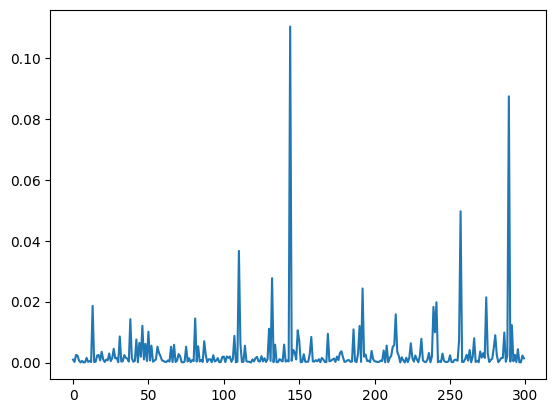

In [ ]:
plt.plot(probs.detach().cpu().numpy())

In [ ]:
details

[]

In [ ]:
tokens = next(data_loader)
logits = model(tokens)
loss = loss_fn(logits, tokens)

In [ ]:
tokens = torch.tensor([[2, 1]], dtype=torch.long, device=device)
logits = model(tokens)
print(logits.argmax(dim=2))
loss = loss_fn(logits, tokens).item()
print(loss)

tensor([[5, 2]], device='cuda:0')
3.707723379135132


In [ ]:
logits[0][0].softmax(dim=0)

tensor([1.1872e-02, 2.4533e-02, 1.5753e-03, 4.6441e-04, 3.0527e-02, 8.5076e-01,
        5.5864e-04, 3.2492e-02, 4.7218e-02], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [ ]:
logits[0][0].softmax(dim=0).argsort()[0].item()

3

In [ ]:
from matplotlib import pyplot as plt

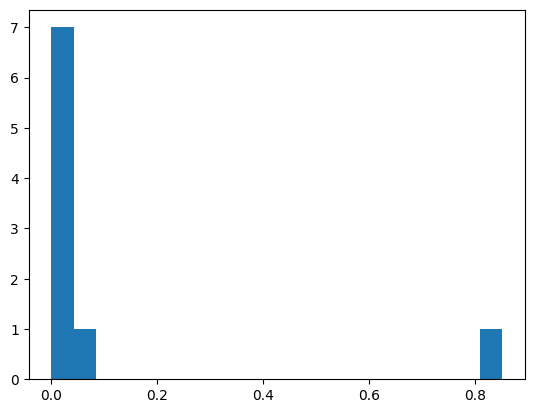

In [ ]:
plt.hist(logits[0][0].softmax(dim=0).detach().cpu().numpy(), bins=20);

In [ ]:
torch.save(model.state_dict(), os.path.join(dir_save_model, "no_pos_experiment_state_dict_v0.pth"))